# Processed Data from Experiment

This is data that has been sequenced and mapped to valid combinatorial barcode combos. 
Each sequence contains a few pieces of information and roughly looks like the following:

**Spatial Barcode 1 --- Const Seq --- 5bp UMI --- S/R oligos -- 5bp UMI -- Const Seq -- Spatial Barcode 2**
* The whole sequencing read is constructed from joining two molecules together, one from one bead and another from another bead

* Spatial barcode 1 is the spatial barcode of the bead we are looking at. This was the DNA that was physcially attached to a bead. There are 96^4 possible combinations of this barcode
* Constant Sequence is a place where we can do in situ sequencing, etc... 
* S/R oligos are the ends of the two complimentary oligos that have annealed and found each other
* Spatial barcode 2 is the spatial barcode from the diffusing molecule. It has been released on another bead and found its way over to this bead
* the Two 5 base UMIs are joined and treated as a single 10 base UMI.
* Reads are collapsed if they have the same 10 base UMI, the same S/R sequence and the same spatial barcodes. 



In [159]:
import requests

def download_save_data(link, path):
    """
    Download and save data from link to path
    :param link: link to download data
    :param path: path to save data
    :return: None
    """
    with open(path, 'wb') as f:
        response = requests.get(link)
        f.write(response.content)

In [160]:
# Download the nextera_interactions.txt file
download_save_data('https://www.dropbox.com/s/fqgdelppxp3fedz/nextera_interactions.txt?dl=1', 'nextera_interactions.txt')

# Explore the data

In [174]:
# %pip install numpy
# %pip install scipy
# %pip install pandas
# %pip install matplotlib
# %pip install plotnine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
from io import StringIO
import scipy as sp
from scipy.sparse import coo_matrix


In [162]:
# Read a sparse matrix file into a pandas dataframe
def create_sparse_matrix_from_file(file_path):
    try:
        # Read data from CSV file
        df = pd.read_csv(file_path)
        
        # Convert columns to integers
        df[['R1_bc', 'R2_bc', 'count']] = df[['R1_bc', 'R2_bc', 'count']].astype(int)
        
        # Extract row indices, column indices, and values
        row_indices = df['R1_bc'].to_numpy()
        col_indices = df['R2_bc'].to_numpy()
        values = df['count'].to_numpy()
        
        # Determine the shape of the matrix
        nrows = row_indices.max() + 1
        ncols = col_indices.max() + 1
        
        # Create and return the sparse matrix
        return coo_matrix((values, (row_indices, col_indices)), shape=(nrows, ncols))
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [163]:
file_path = "nextera_interactions.txt"
sparse_matrix_all_interactions = create_sparse_matrix_from_file(file_path)

In [6]:
sparse_matrix_all_interactions.row

array([    0,     0,     0, ..., 94246, 94246, 94247], dtype=int32)

# Plot the number of unique interactions per bead (R1 and R2)

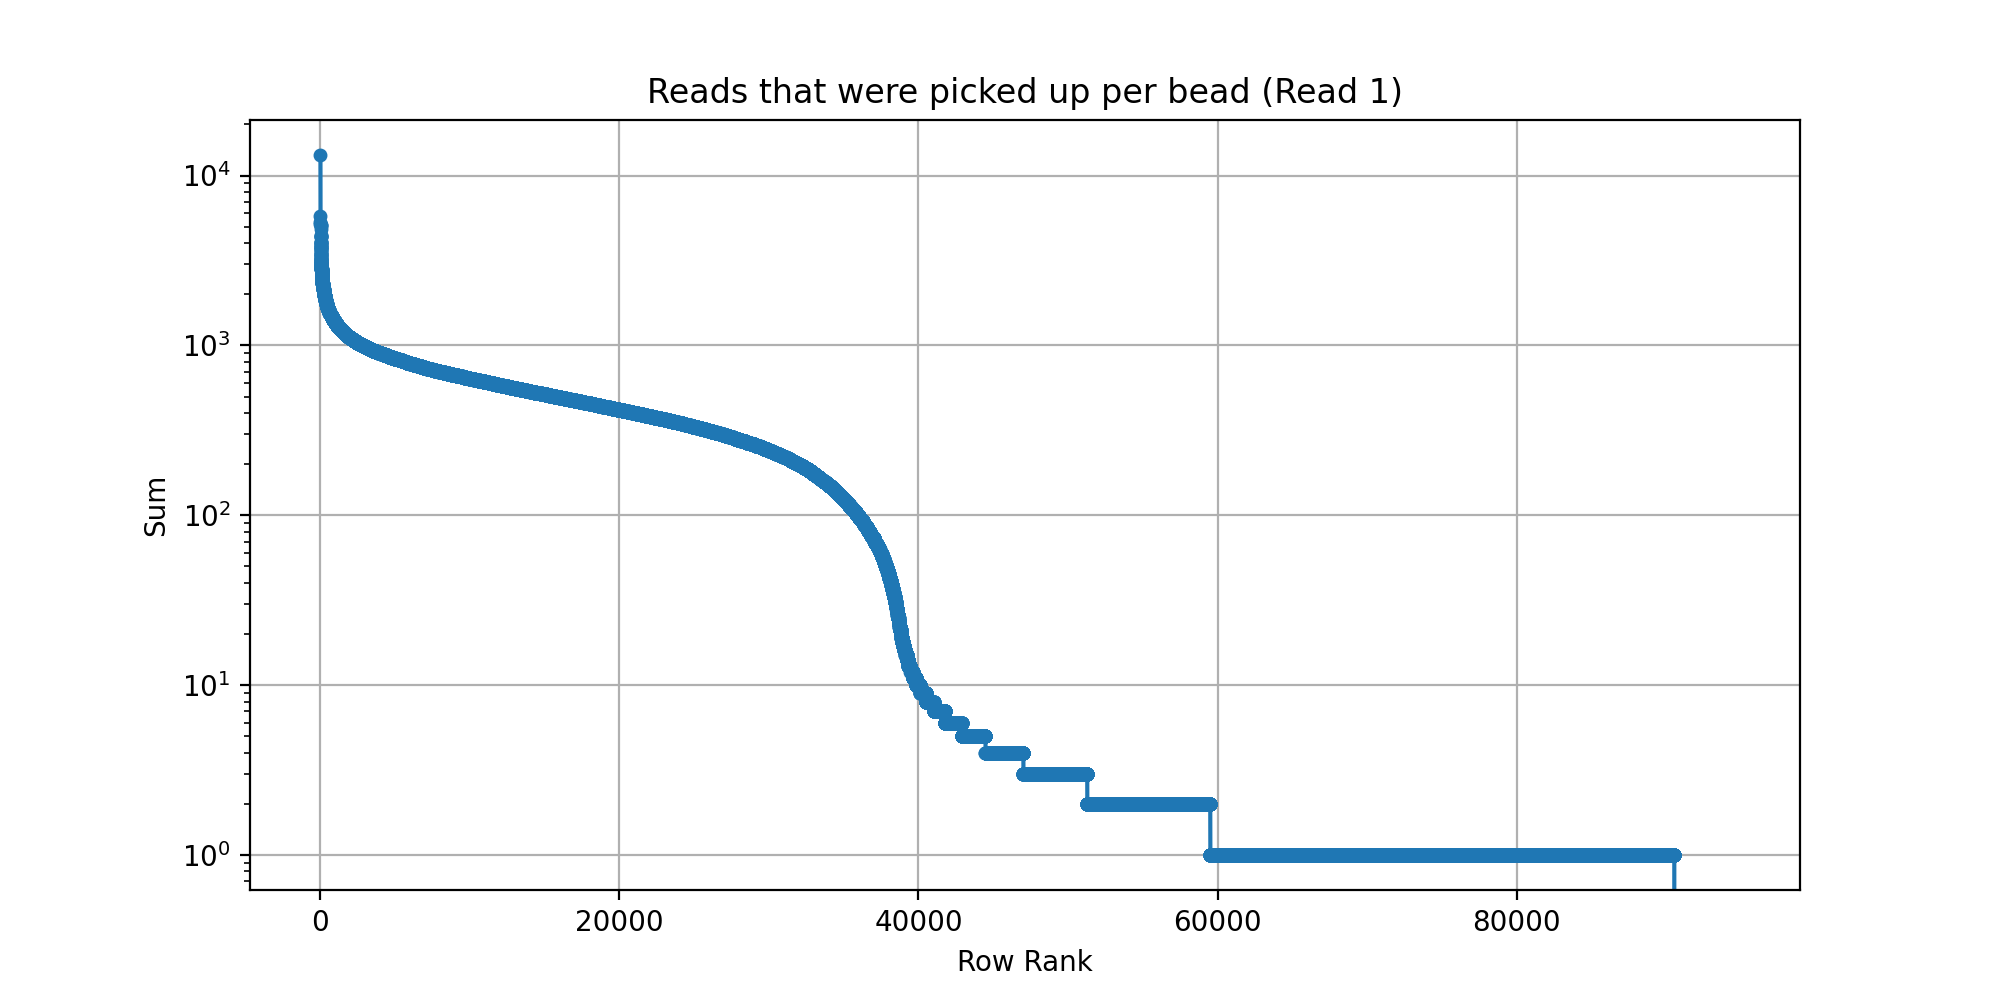

In [164]:
# Sum the rows
row_sums = np.array(sparse_matrix_all_interactions.sum(axis=1)).flatten()

# Sort the sums in descending order
sorted_sums = np.sort(row_sums)[::-1]

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(sorted_sums, marker='o', linestyle='-', markersize=4)
plt.title('Reads that were picked up per bead (Read 1)')
plt.xlabel('Row Rank')
plt.ylabel('Sum')
plt.yscale('log')
plt.grid(True)
plt.show()

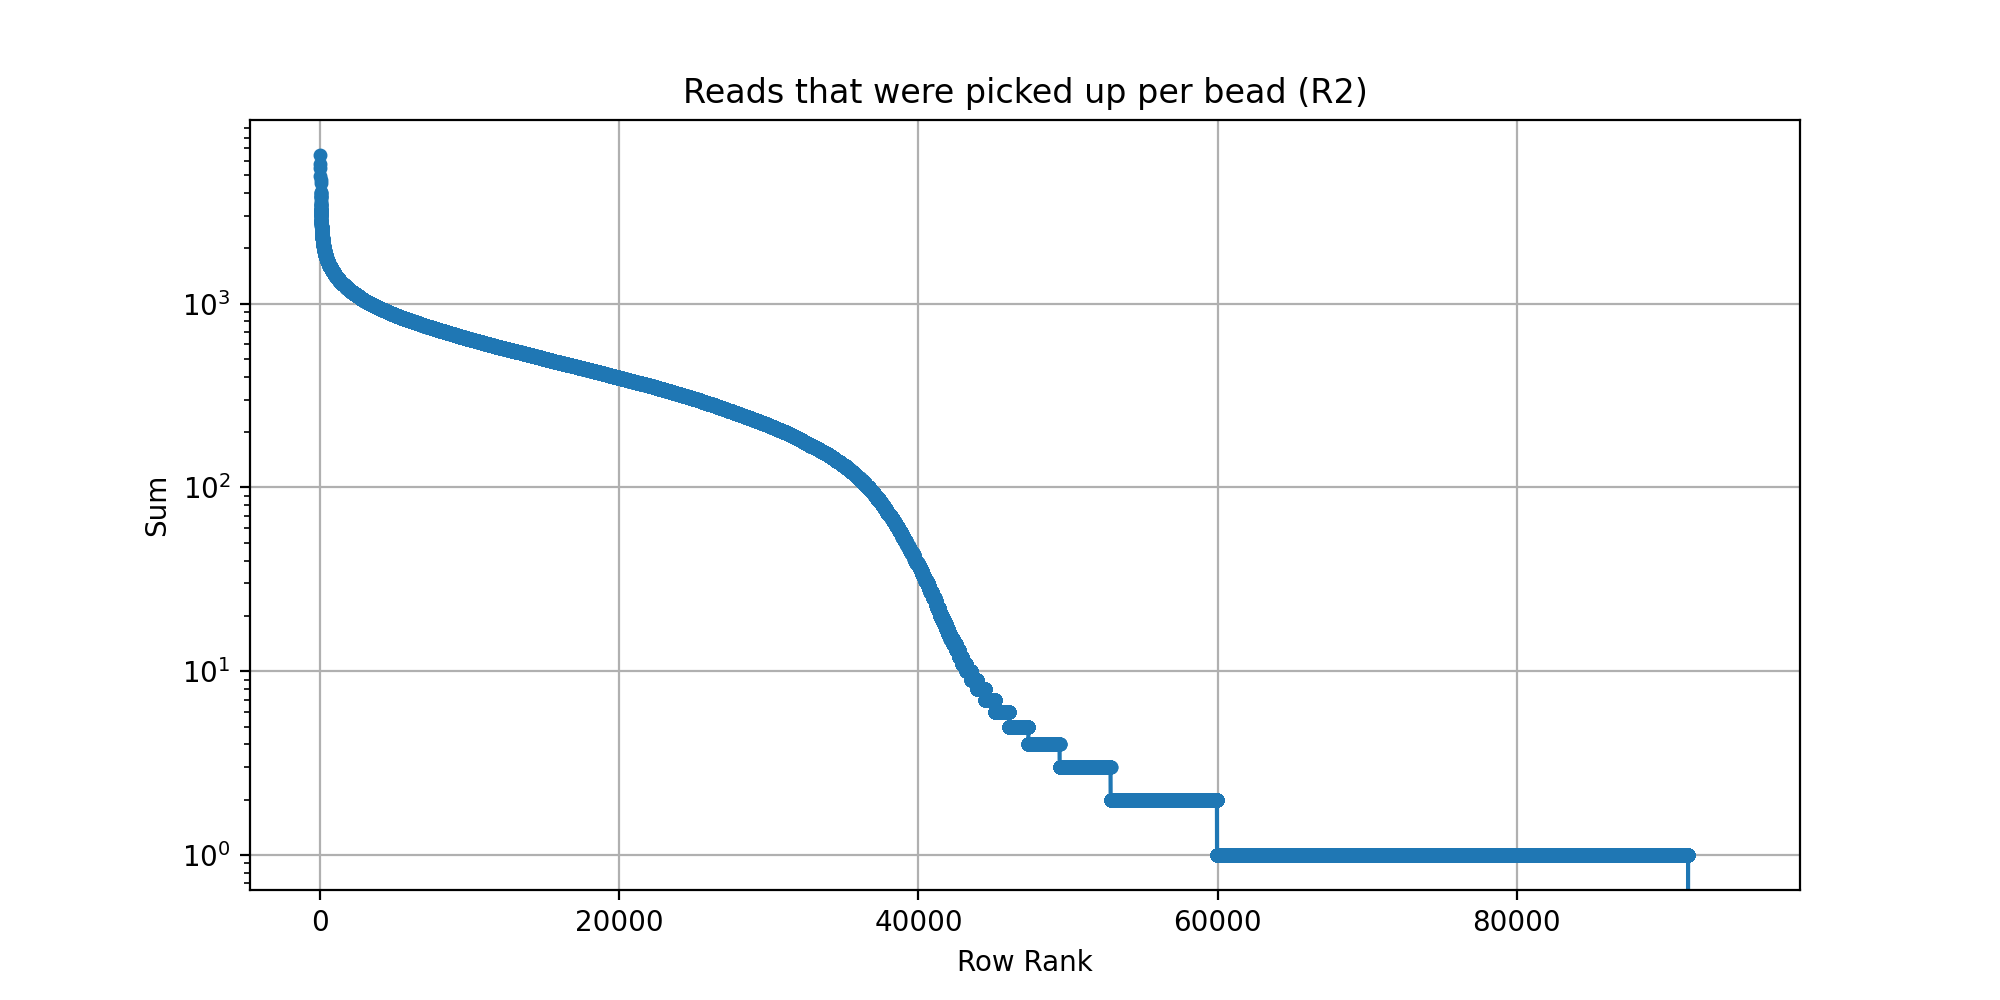

In [165]:
# Sum the columns
col_sums = np.array(sparse_matrix_all_interactions.sum(axis=0)).flatten()

# Sort the sums in descending order
sorted_sums = np.sort(col_sums)[::-1]

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(sorted_sums, marker='o', linestyle='-', markersize=4)
plt.title('Reads that were picked up per bead (R2)')
plt.xlabel('Row Rank')
plt.ylabel('Sum')
plt.yscale('log')
plt.grid(True)
plt.show()


# What's going on here?
This is called a knee plot by single cell folks. We have sequenced these beads in bulk and we have no idea which of the beads are on our array. There is a space of 94 <sup>4</sup> possible barcode combinations. We think that there were roughly 40K beads in this experiment (based on microscopy data). To get real beads we set some read (UMI) cutoff. Beads below this cutoff are discarded, while beads above this cutoff are kept. Below I am plotting a scatter plot of the row sums vs the col sums for a given barcode. The intution here is that these are oligos that were either retained (colsums -- `axis == 0`) or released and floated to another bead (rowsums or `axis == 1`) 

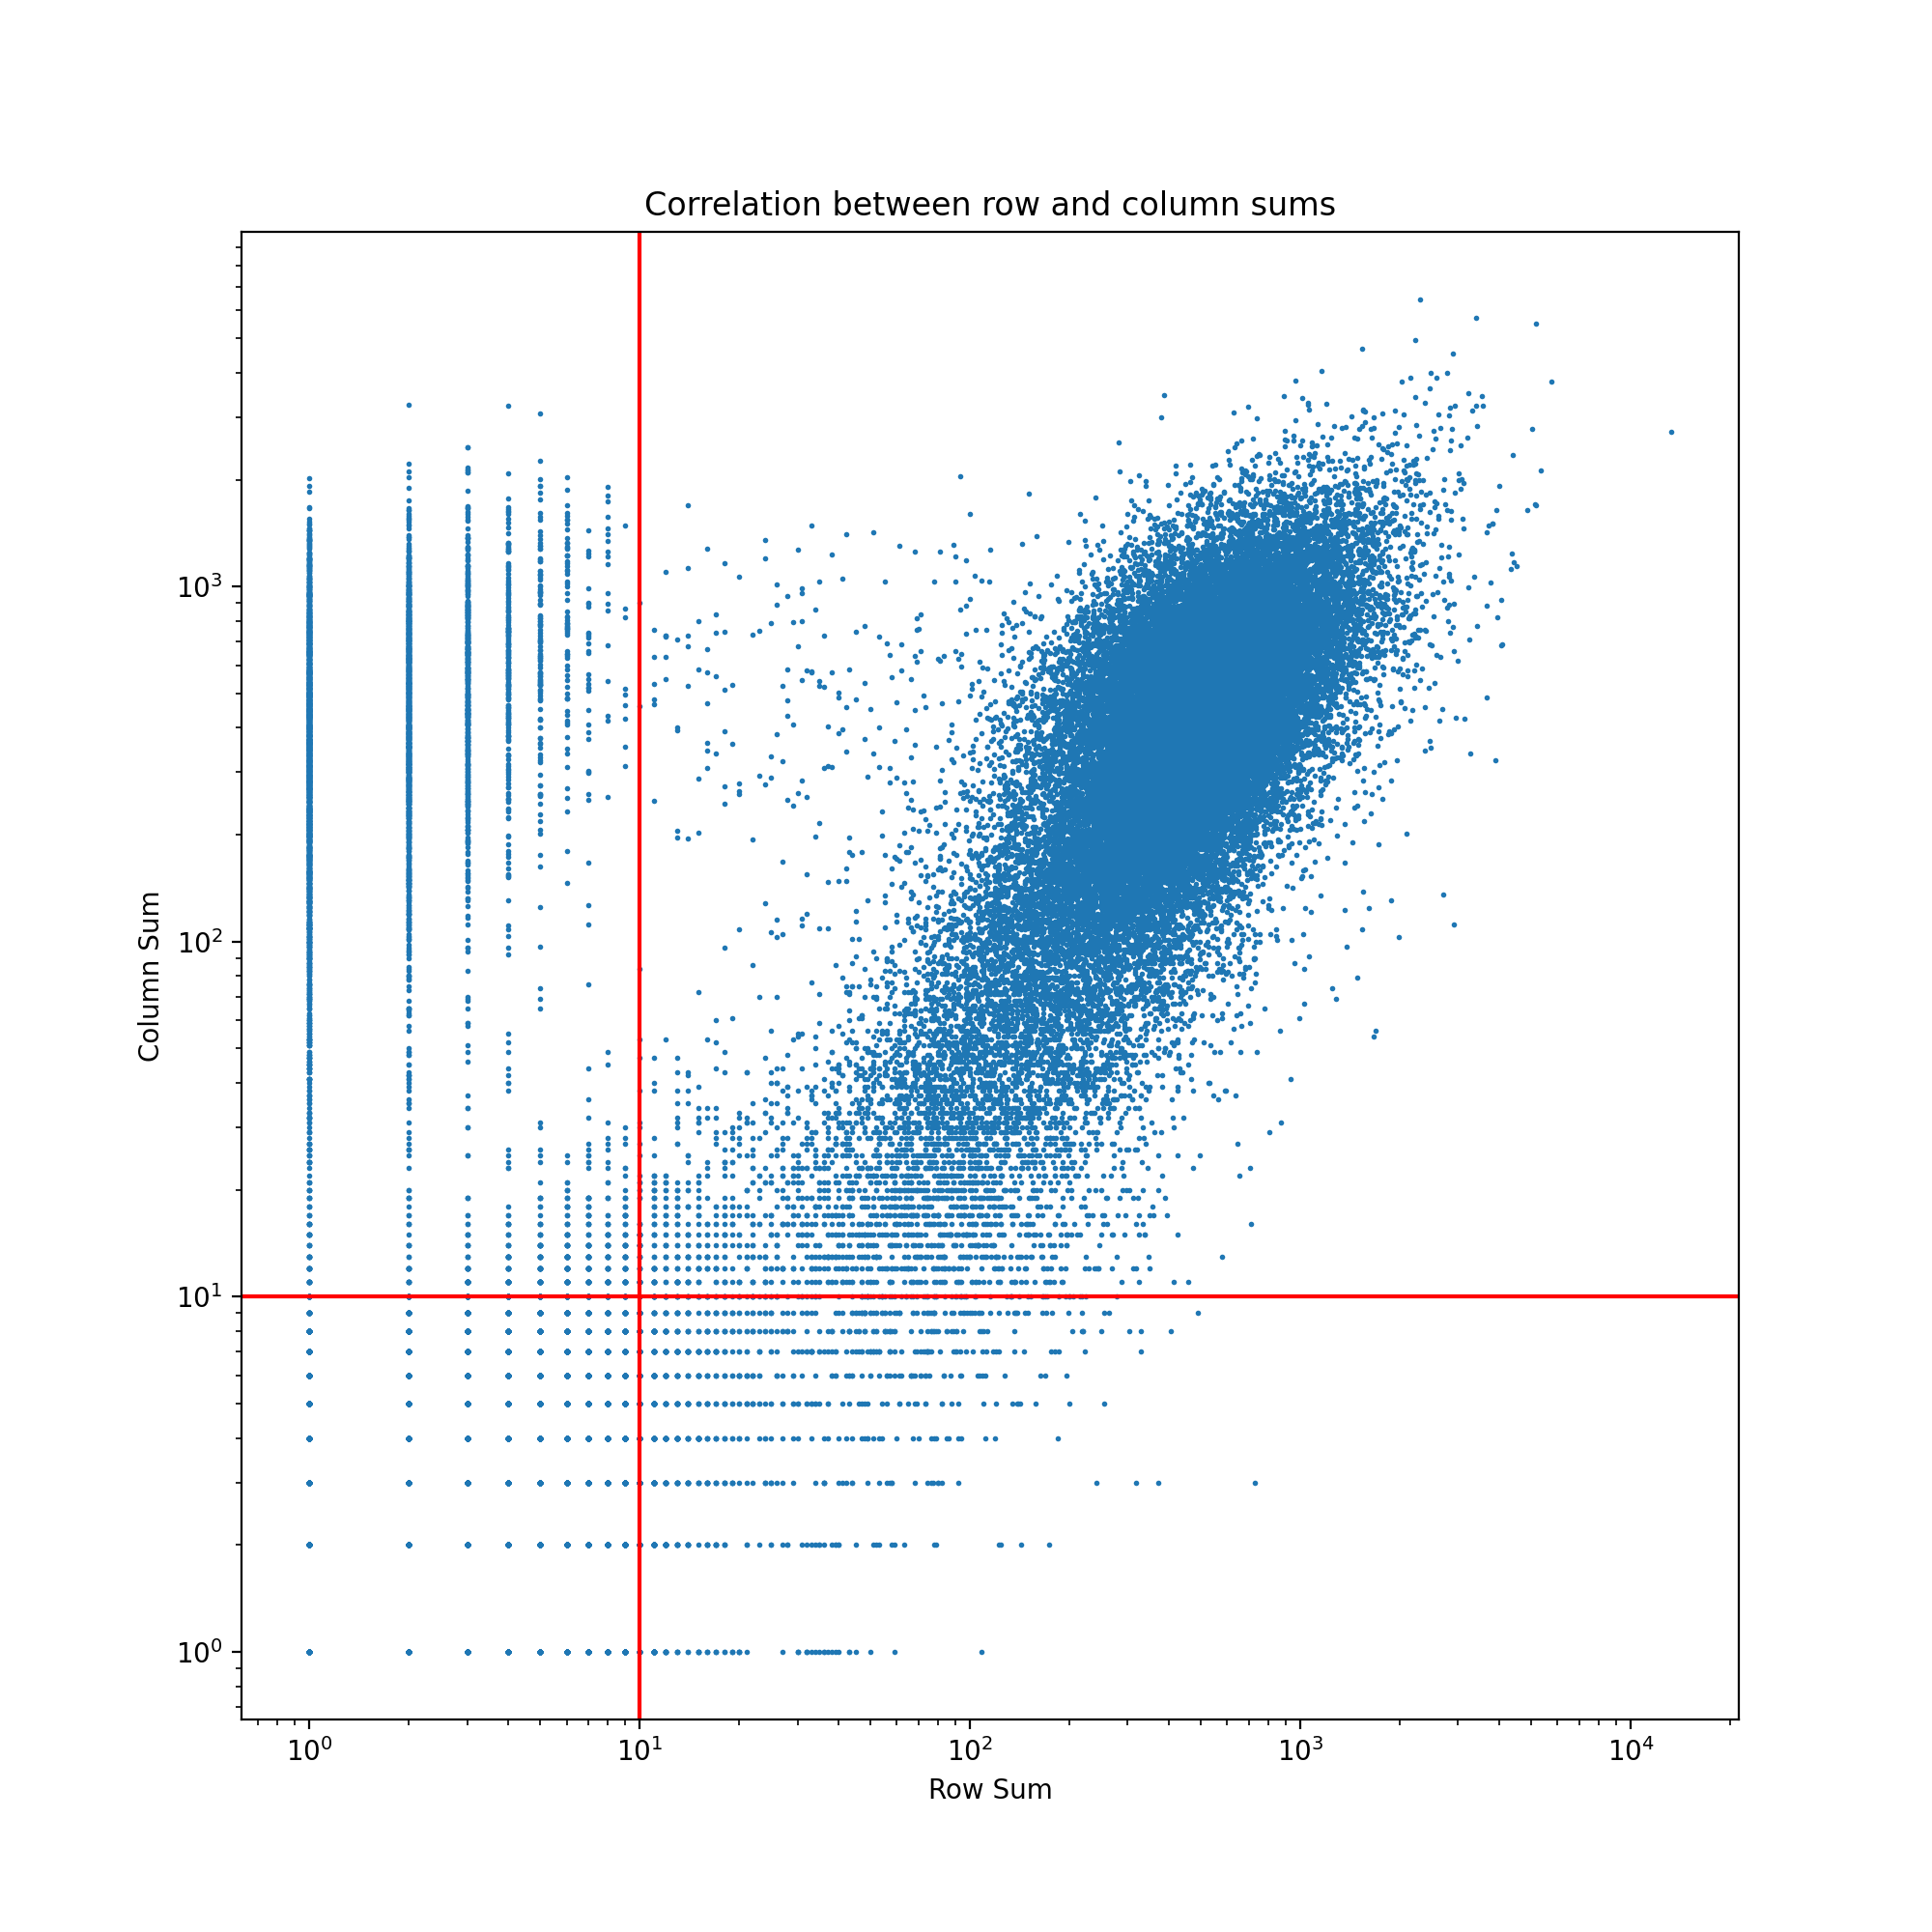

In [166]:
df_row_col_corr = pd.DataFrame({'row_sums': row_sums + 1 , 'col_sums': col_sums + 1 })
plt.figure(figsize=(10, 10))
plt.title('Correlation between row and column sums')
plt.xlabel('Row Sum')
plt.ylabel('Column Sum')
plt.scatter(row_sums, col_sums, s=1)
plt.yscale('log')
plt.xscale('log')
plt.axvline(x=10, color='r', linestyle='-', label='Vertical Line')

# Adding a horizontal line at y = 0
plt.axhline(y=10, color='r', linestyle='-', label='Horizontal Line')

plt.show()


This is displaying the intution for setting a cutoff at about 10 reads coming from both the Read1 side and the Read2 side. Most of the density is in the top right quadrant, but interestingly, there is a lot of extra "noise" in the top left quadrant. This would be an interesting thing to investiage and keep in mind. It's possible that this channel is somehow more sensitive or messy in some way.

# Distribution of individual beads

In [167]:
filtered_rows = df_row_col_corr['row_sums'] > 10
filtered_cols = df_row_col_corr['col_sums'] > 10 

filtered_indices = df_row_col_corr.loc[filtered_rows & filtered_cols, :].index
filtered_matrix = sparse_matrix_all_interactions.tocsr()[filtered_indices,:][:,filtered_indices]


In [168]:
def get_top_n_from_row(sparse_row, top_n=100):
    # Converting the sparse row to a dense numpy array
    dense_array = np.array(sparse_row.todense()).flatten()
    
    # Getting the indices that would sort the array
    sorted_indices = np.argsort(dense_array)
    
    # Taking the top N indices
    top_indices = sorted_indices[-top_n:]
    
    # Getting the corresponding values
    top_values = dense_array[top_indices]
    
    return top_indices, top_values


In [169]:
num_samples = 12

result_frames = []

for _ in range(num_samples):
    rand_index = np.random.randint(filtered_matrix.shape[0])
    row = filtered_matrix.getrow(rand_index)
    top_indices, top_values, ranks = get_nonzero_from_row(row)
    df_row = pd.DataFrame({'Index': rand_index, 'Column': top_indices, 'Value': top_values, 'Rank': ranks})

    result_frames.append(df_row)

result_df = pd.concat(result_frames, ignore_index=True)
result_df.head(n = 100)



,Index,Column,Value,Rank
0,36775,4498,1,166
1,36775,15426,1,165
2,36775,6944,1,164
3,36775,997,1,163
4,36775,998,1,162
...,...,...,...,...
95,36775,7176,10,5
96,36775,795,14,4
97,36775,16223,19,3
98,36775,4377,30,2


/Users/sanjay/Library/Python/3.11/lib/python/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


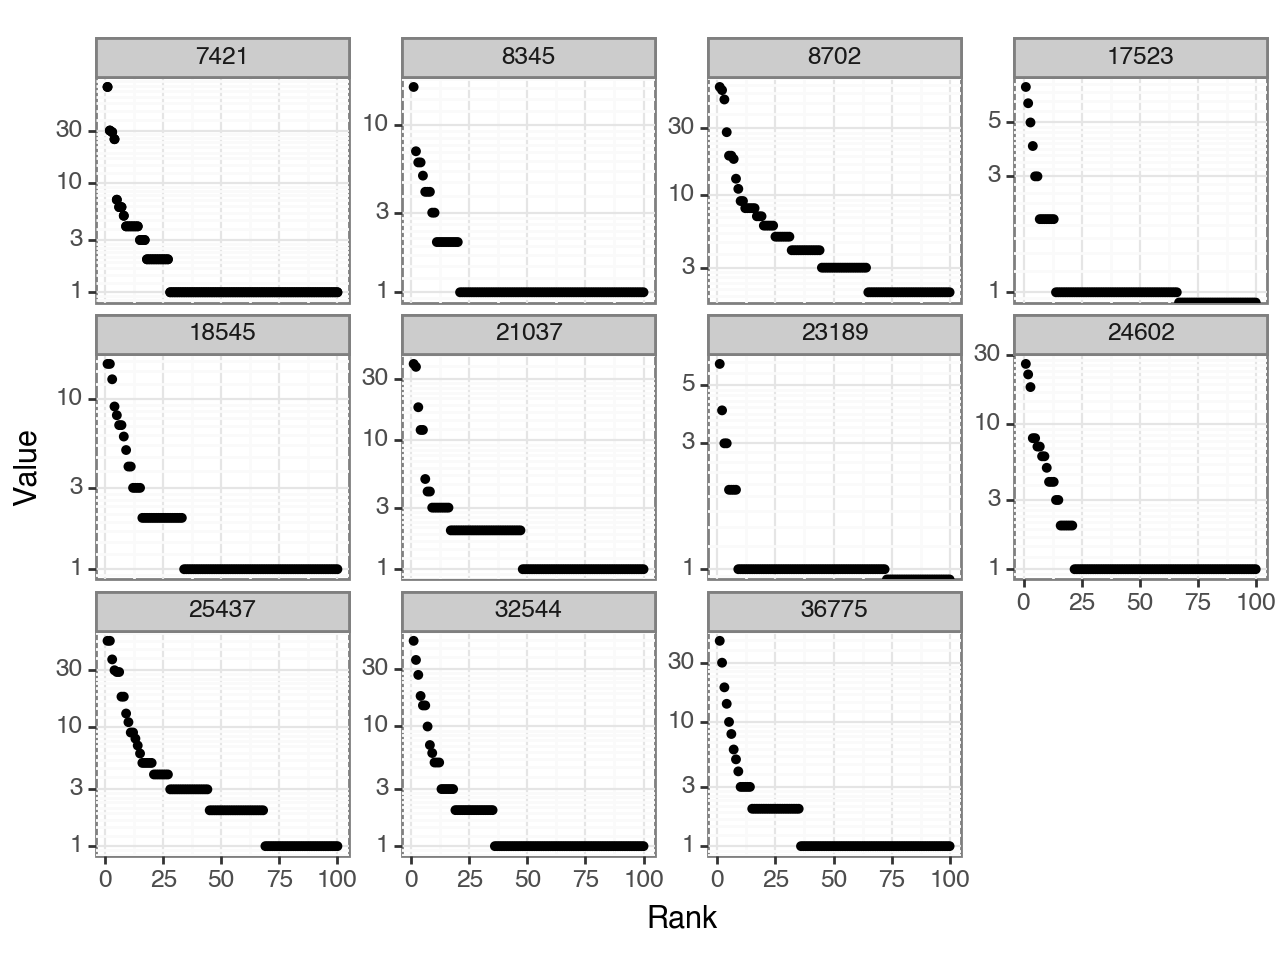

<Figure Size: (640 x 480)>

In [170]:
(
    ggplot(result_df, aes(x='Rank', y='Value')) +
    geom_point(size = 1) +
    facet_wrap('Index', scales='free_y',nrow = 3) +
    scale_y_log10() +
    theme_bw() 
)

We can see that there is a clear enrichment for certain beads interacting with other beads.

We could use what we know about the beads as a prior to bias the distribution towards the euclidean version we expect

# TODO: Add information regarding the Sender Receiver of each bead 

# Write out file in Sparse Matrix Format so that it can be used in other notebooks


In [175]:
sp.sparse.save_npz('filtered_matrix.npz', filtered_matrix)
# Write out the sparse matrix to a file
np.savez_compressed('count.matrix.filtered.MM', filtered_matrix)
